# Preamble

In [10]:
# Project functions
from utils.utils import *
from utils.network import *
from utils.visualization import *
from utils.info import *

# External imports
import numpy as np
import re
import subprocess
import networkx as nx
import random
from multiprocessing import Pool
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [11]:
standarize_plot_parameters()

### Utility functions

In [248]:
def morph_from_G1_to_G2(G, Gt, num_swaps):
    """Exchanges num_swaps edges from G with num_swap edges from Gt"""
    def _dependent_edge_swaps(Gs, Gt):
        
        Gc = Gs.copy()
        
        empty = 0
        done = False
        
        try:
            u, x = random.choice(list(set(Gc.edges()) - set(Gt.edges())))  # REMOVE random edge not in Gt
            Gc.remove_edge(u, x)
        except IndexError:
            done += 1
        
        try:
            v, y = random.choice(list(set(Gt.edges()) - set(Gc.edges())))  # ADD random edge not in Gc
            Gc.add_edge(v, y)
        except IndexError:
            done += 1
        
        if done == 2:
            done = True
            
        return Gc, done
    
    def _jaccard_sim(a, b):
        return len(a & b) * 1.0 / len(a | b)
    
    Gs = G.copy()
    
    for _ in range(num_swaps):
        Gs, done = _dependent_edge_swaps(Gs, Gt)
        if done:
            if _jaccard_sim(set(Gs.edges()), set(Gt.edges())) != 1:
                Gs = Gt
            break
            
    return Gs

def signal_residual_AMI(layer_commu):
    """Returns the average AMI between signal and residual layers"""
    return np.mean([
        AMI_score(
            invert_partition(layer_commu[1]),
            invert_partition(layer_commu[Ls])
        )
        for Ls in [0, 2]
    ])

def community_isolation(node_flow, partition, L_arr):
    """Returns the flow fraction of total flow inside L_arr layers"""
    community_flow = defaultdict(float)
    for ln, flow in node_flow.items():
        l, n = map(int, ln.split("_"))
        if l in L_arr:
            community_flow[partition[n]] += flow
    return community_flow

# Analysis

## Choose benchmark network

We want a benchmark network with significant clustering and some but not too much overlap between communities in independent modes. There should also be enough links inside of communities so that we can make quite sparse samples of networks without losing the planted community structure.

#### Hyperparameters

In [228]:
#LFR_params = dict(N=512, k=20, maxk=32, mu=0.05, t1=10, t2=10, maxc=32)
#LFR_params = dict(N=512, k=16, maxk=32, mu=0.05, t1=10, t2=10, maxc=32)  # 1
#LFR_params = dict(N=512, k=16, maxk=32, mu=0.05, t1=10, t2=10, maxc=24)  # 2
LFR_params = dict(N=512, k=12, maxk=32, mu=0.05, t1=10, t2=10, maxc=24)  # 3
figures_folder = "figures"

#### Plot an example of that network

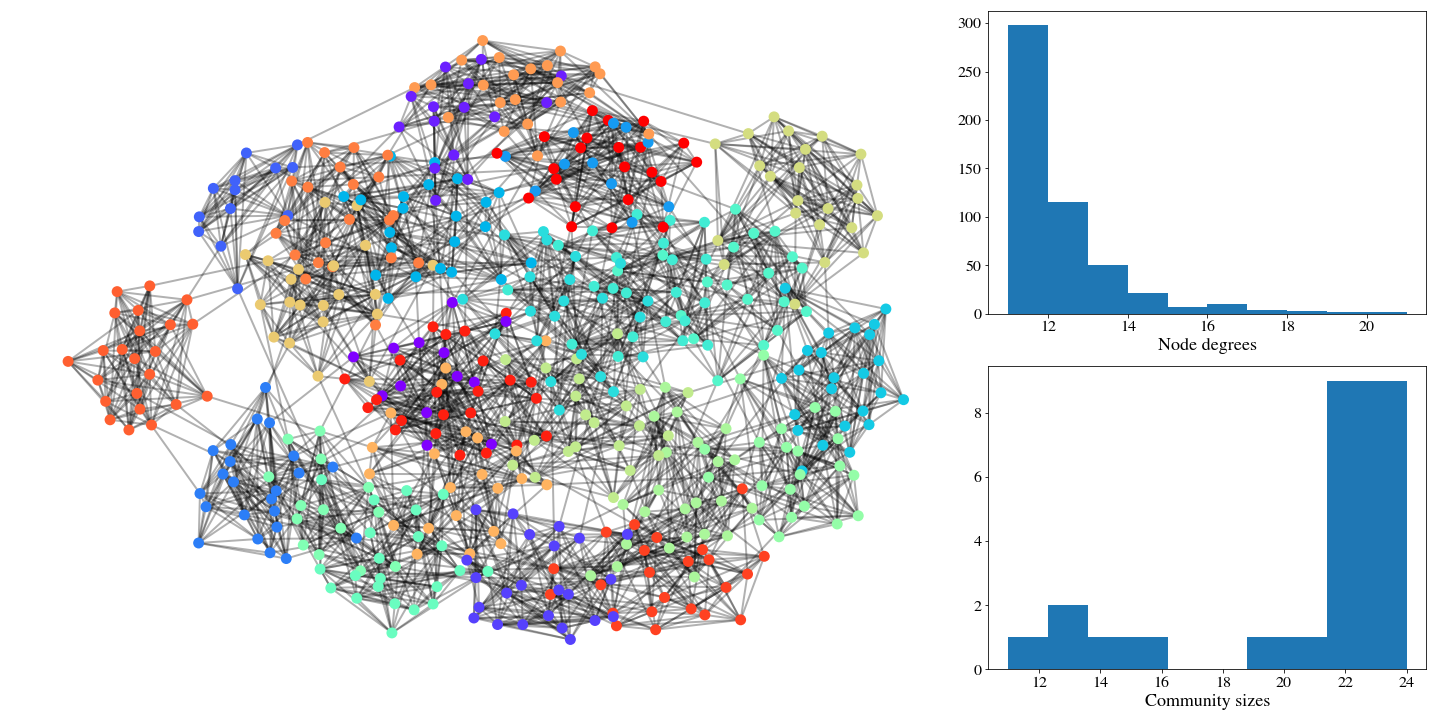

In [219]:
# An example of what a mode looks like
G_example, partition_example = LFR_benchmark_graph(**LFR_params)

plt.figure(figsize=(20, 10))

plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
draw(G_example, partition=partition_example)

plt.subplot2grid((2, 3), (0, 2))
plt.hist([d for n, d in G_example.degree()])
plt.xlabel("Node degrees", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot2grid((2, 3), (1, 2))
plt.hist([len(nodes) for n, nodes in invert_partition(partition_example).items()])
plt.xlabel("Community sizes", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

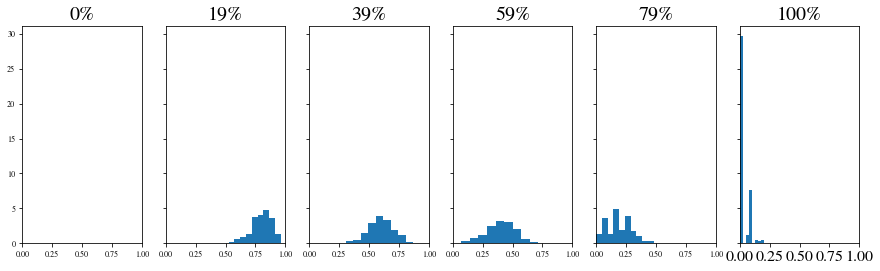

In [220]:
GS = LFR_benchmark_graph(**LFR_params)[0]
GT = LFR_benchmark_graph(**LFR_params)[0]
GR = GS.copy()

num_e = len(GS.edges())
swap_vals = map(int, np.linspace(0, num_e, 6))

fig, ax = plt.subplots(1, 6, figsize=(15, 4), sharey=True, sharex=True)
prev_n_swaps = 0
for i, n_swaps in enumerate(swap_vals):

    GR = morph_from_G1_to_G2(GR, GT, (n_swaps - prev_n_swaps)) 
    prev_n_swaps = n_swaps
    
    ax.ravel()[i].set_title(str(int(round(n_swaps*100/num_e))) + "%", fontsize=20)
    ax.ravel()[i].hist(jssim_dist(GS, GR), normed=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1)
plt.show()

## Fig 5.b
(Not very parallelizable because of sequential edge-exchange)

In [229]:
def cluster_and_measure(args):
    """Worker function for running Infomap."""
    _, _layer_commu, _, _ = Infomap(*args)
    return signal_residual_AMI(_layer_commu), args[-1][3:]

def simulate_AMI_vs_s((N_swap_iter, G_signal, G_target, _iter)):

    # Residual networks and their independent target networks
    G_residual = G_signal.copy()
    
    # Values to loop over
    num_e = len(G_signal.edges())
    swap_vals = map(int, np.linspace(0, num_e, N_swap_iter))
    
    # Create arrays to catch results in
    AMI_NFC, AMI_FC, AMI_AC, AMI_NC = [], [], [], []
    
    # Schedule tasks
    data = []
    
    prev_n_swaps = 0
    for n_swaps in swap_vals:

        # Morph residual layers
        G_residual = morph_from_G1_to_G2(G_residual, G_target, (n_swaps - prev_n_swaps)) 
        
        # Store number of swaps
        prev_n_swaps = n_swaps
        
        # Make pajek representation of multilayer network
        pajek_synth = graph_list_to_pajek([G_signal, G_residual, G_signal])
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, 0.25) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_r%s%d' % (method, n_swaps, np.random.randint(int(1e9)))
            ])
    
    for measured_AMI, pid in map(cluster_and_measure, data):
        method = pid.split("_")[0]
        locals()['AMI_%s' % method].append(measured_AMI)
        
    print _iter
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_NC
    

def run_simulation(N_swap_iter, n_iter, *args):
    
    if args == ():
        NFC, FC, AC, NC = [], [], [], []
    else:
        NFC, FC, AC, NC = args
    
    mapping = dict(zip(range(LFR_params['N']), range(LFR_params['N'])[::-1]))
    data = [
        (N_swap_iter, LFR_benchmark_graph(**LFR_params)[0], nx.relabel_nodes(LFR_benchmark_graph(**LFR_params)[0], mapping), _iter)
        for _iter in range(n_iter)
    ]
                    
    for AMI_NFC, AMI_FC, AMI_AC, AMI_NC in map(simulate_AMI_vs_s, data):
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        NC.append(AMI_NC)
        
    return NFC, FC, AC, NC

In [ ]:
NFC, FC, AC, NC = run_simulation(50, 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


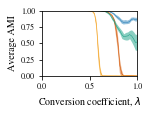

In [237]:
X = [np.linspace(0, 1, 50)]

plt.figure(figsize=(3.42/2, 2.4/2))
confidence_intervals(X, NFC, c="#d35400", label="NFC", lw=0.5)
confidence_intervals(X, FC, "#2980b9", label="FC", lw=0.5)
confidence_intervals(X, AC, c="#16a085", label="AC", lw=0.5)
confidence_intervals(X, NC, c="#f39c12", label="NC", lw=0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Conversion coefficient, $\lambda$")
plt.ylabel("Average AMI")

#plt.legend(loc="upper right", fontsize=5, frameon=False)
plt.savefig("%s/Fig5b.pdf" % figures_folder)
plt.show()


## Fig. 5c

In [262]:
def cluster_and_measure(args):
    """Worker function for running Infomap."""
    args, partition = args
    _, _, node_flow, _ = Infomap(*args)
    return sum(community_isolation(node_flow, partition, [0, 2]).values()), args[-1][3:]

def flow_vs_conversion((N_swap_iter, _iter)):

    G_signal, partition_signal = LFR_benchmark_graph(**LFR_params)
    G_target, _ = LFR_benchmark_graph(**LFR_params)
    
    # Residual networks and their independent target networks
    G_residual = G_signal.copy()
    
    # Values to loop over
    num_e = len(G_signal.edges())
    swap_vals = map(int, np.linspace(0, num_e, N_swap_iter))
    
    # Create arrays to catch results in
    flow_NFC, flow_FC, flow_AC, flow_NC = [], [], [], []
    
    # Schedule tasks
    data = []
    
    prev_n_swaps = 0
    for n_swaps in swap_vals:

        # Morph residual layers
        G_residual = morph_from_G1_to_G2(G_residual, G_target, (n_swaps - prev_n_swaps)) 
        
        # Store number of swaps
        prev_n_swaps = n_swaps
        
        # Make pajek representation of multilayer network
        pajek_synth = graph_list_to_pajek([G_signal, G_residual, G_signal])
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([[
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, 0.99) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_r%s%d' % (method, n_swaps, np.random.randint(int(1e9)))
            ], partition_signal])
    
    for measured_flow, pid in map(cluster_and_measure, data):
        method = pid.split("_")[0]
        locals()['flow_%s' % method].append(measured_flow)
        
    print _iter
    
    return flow_NFC, flow_FC, flow_AC, flow_NC
    

def run_simulation(N_swap_iter, n_iter, *args):
    
    if args == ():
        NFC, FC, AC, NC = [], [], [], []
    else:
        NFC, FC, AC, NC = args
    
    data = [
        (N_swap_iter, _iter)
        for _iter in range(n_iter)
    ]
                    
    for flow_NFC, flow_FC, flow_AC, flow_NC in map(flow_vs_conversion, data):
        NFC.append(flow_NFC)
        FC.append(flow_FC)
        AC.append(flow_AC)
        NC.append(flow_NC)
        
    return NFC, FC, AC, NC

In [263]:
flow_NFC, flow_FC, flow_AC, flow_NC = run_simulation(50, 1)

0


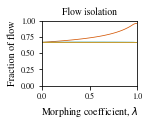

In [267]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals(X, flow_NFC, c="#d35400", label="JSL", lw=0.75)
confidence_intervals(X, flow_FC, c="#2980b9", label="FL", lw=0.75)
confidence_intervals(X, flow_AC, c="#16a085", label="AL", lw=0.75)
confidence_intervals(X, flow_NC, c="#f39c12", label="NL", lw=0.75)

plt.title("Flow isolation")
plt.xlabel("Morphing coefficient, $\lambda$")
plt.ylabel("Fraction of flow")

plt.ylim(0., 1.)
plt.xlim(0, 1)
plt.savefig("%s/Fig5b.pdf" % figures_folder)
plt.show()